28.11.2023 Meeting

Overview:

[x] Visualize predicted vs true values (scatterplot with seaborn) of model predicting click difference from difference embedding (true difference - predicted difference)

[x] show headlines that scored highly and compare with headlines scored low 

[ ] compare ranking between model using embeddings and embedding difference to predict clicks / click difference

[x] make list of potential explanations of what the model is capturing (speech text / punctuation)

[x] introducing click rate

 

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math

In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [3]:
#Define model - pretrained
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')


In [4]:
#Load data
df = pd.read_csv("C:/Users/mldem/Downloads/upworthy-archive-datasets/upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#Delete some unnecessary columns
print(df.columns)
delete_cols = ["created_at","updated_at","share_text","square"]
df = df.drop(columns=delete_cols)
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]),ndigits=3)
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 4.64 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 2.11 packages with the same eyecatcher id and same clickability_test_id
clicks =torch.tensor(df.clicks.values)

Index(['Unnamed: 0', 'created_at', 'updated_at', 'clickability_test_id',
       'excerpt', 'headline', 'lede', 'slug', 'eyecatcher_id', 'impressions',
       'clicks', 'significance', 'first_place', 'winner', 'share_text',
       'square', 'test_week'],
      dtype='object')
Unnamed: 0       4.641032
excerpt          4.147870
headline         4.641032
lede             4.638130
slug             4.641032
eyecatcher_id    4.635272
impressions      4.641032
clicks           4.641032
significance     4.641032
first_place      4.641032
winner           4.641032
test_week        4.641032
clickrate        4.641032
dtype: float64
Unnamed: 0      2.117931
excerpt         1.892597
headline        2.117931
lede            2.116605
slug            2.117931
impressions     2.117931
clicks          2.117931
significance    2.117931
first_place     2.117931
winner          2.117931
test_week       2.117931
clickrate       2.117931
dtype: float64


In [5]:
#Load embeddings
with open('full_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']



# 1. Predicting clicks from headline embeddings with ridge regression (incl. comparison with linear)

In [6]:
# Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)

In [7]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train) #0.1629
predictions = ridge_model.predict(X_test) #alpha = 10
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions"] = ridge_model.predict(stored_embeddings)
print("Spearman correlation:",spearmanr(df.sort_values(["predictions"]).loc[:,"headline"],df.sort_values(["clicks"]).loc[:,"headline"]))



Ridge Regression MSE for click difference: 1680.7123980704882
Ridge Regression R2 for click difference: 0.15630751841239166
Spearman correlation: SignificanceResult(statistic=-0.0003500375600872288, pvalue=0.909458959910692)


### Last 20 predicted

In [8]:
df.sort_values(["predictions"],ascending=True).loc[:,['headline']][:20]



,headline
43935,Technology that sorts frogs from green beans o...
54644,Some Household Tips That Make Sense And Save W...
21085,How To Change Lives? Partnership. Encouragemen...
100883,Good water here is so precious that they learn...
32489,Music Is Power. Here's How We Can Harness It.
35245,Water Poverty Has A Zip Code
31121,"What Do You Call A School With No Libraries, S..."
2599,Water is a job creator. It's big time.
9273,Some quick ideas on how we can win the war on ...
33485,Struggling To Provide Opportunities In The Dev...


#### Potential explanations:
#### 1. Short sentences
#### 2. Capital letters
#### 3. Punctuation - exlamation marks, question marks, +

### Last 20 true

In [9]:

df.sort_values(["clicks"],ascending=True).loc[:,['headline',"clicks"]][:20]


,headline,clicks
99145,"There's a lot to be happy about. For example, ...",0
8063,Folks in this city survive on $3 per day. He c...,0
99577,They're saying some pretty brave things in thi...,0
99574,"Yes! This is the brave, all-inclusive, pro-cho...",0
9940,This is what deforestation can do to your city...,0
33840,It Only Took Rachel Maddow 48 Seconds To Debun...,0
33839,It Only Took Rachel Maddow 48 Seconds To Shut ...,0
37170,"In Case You Missed It, Here's What The Trayvon...",0
37172,"In Case You Missed It, Here's What The Trayvon...",0
37175,"In Case You Missed It, Here's What The Trayvon...",0


#### Potential explanations:
#### 1. No famous names
#### 2. Focus on the reader - imagine if, what would happen if you

## Top 20 predicted

In [10]:
df.sort_values(["predictions"],ascending=False).loc[:,['headline']][:20]

,headline
45858,Watch This Remarkable Young Woman Render Jon S...
45857,Watch This Amazing Young Woman Render Jon Stew...
48855,Watch This Incredible Young Woman Render Jon S...
48668,Watch This Incredible Young Woman Render Jon S...
48858,Watch This Incredible Young Woman Render Jon S...
48857,Watch This Incredible Young Woman Render Jon S...
48860,Watch This Incredible Young Woman Render Jon S...
48856,Watch This Incredible Young Woman Render Jon S...
45839,Watch This Incredible Young Woman Render Jon S...
48669,Watch This Incredible Young Woman Render Jon S...


#### Potential explanations:
#### 1. Call to action words - "Watch"
#### 2. Capital letters

### Ridge with clickrate instead of clicks

In [11]:

clickrate =torch.tensor(df.clickrate.values)

X_train, X_test, y_train, y_test = train_test_split(stored_embeddings,clickrate, test_size=0.2)
# Ridge Model

ridge_model_clickrate =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model_clickrate.fit(X_train, y_train)
ridge_model_clickrate.score(X_train,y_train) #0.1629
predictions_clickrate = ridge_model_clickrate.predict(X_test) #alpha = 10
rmse_clickrate = mean_squared_error(y_test, predictions_clickrate)

predictions_clickrate_all = ridge_model_clickrate.predict(stored_embeddings)
print(predictions_clickrate_all.shape[0])


for i in range(predictions_clickrate_all.shape[0]):
    if predictions_clickrate_all[i] < 0:
        predictions_clickrate_all[i] = 0
        
df["predictions_clickrate_all"] = predictions_clickrate_all

print("Ridge Regression MSE for click difference:", rmse_clickrate)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions_clickrate))






105551
Ridge Regression MSE for click difference: 0.0001322246962630962
Ridge Regression R2 for click difference: 0.168094577567668


### Last 20 predicted

In [12]:
#last 20 predicted
df.sort_values(["predictions_clickrate_all"],ascending=True).loc[:,['headline',"clickrate","predictions_clickrate_all"]][:40]



,headline,clickrate,predictions_clickrate_all
27698,What Group Of People Is So Powerful No One Wan...,0.018,0.0
32104,What Do You Get When You Take A City And Add 1...,0.008,0.0
94141,When The Holidays Become All About Spending Mo...,0.008,0.0
93770,When The Holidays Become All About Spending Mo...,0.007,0.0
3100,One village doesn't depend on ANY outside sour...,0.004,0.0
70396,How Much Money Could You Save By Riding A Bike...,0.005,0.0
31950,How Just One Tree Is Helping San Francisco Gai...,0.003,0.0
31949,What Do You Get When You Take A City And Add 1...,0.005,0.0
8394,"Some are stuck on history, but when it comes t...",0.003,0.0
52351,What If Some Of The Dollars You Spend On Food ...,0.003,0.0


#### Potential explanations:
#### 1. Questions
#### 2. Topics about the future - i.e food shortage, water supply, preparing for tornadoes

### Top 20 predicted

In [13]:

df.sort_values(["predictions_clickrate_all"],ascending=False).loc[:,['headline',"clickrate","predictions_clickrate_all"]][:20]


,headline,clickrate,predictions_clickrate_all
45859,Wow... Watch This Young Woman Render Jon Stewa...,0.057,0.039265
45858,Watch This Remarkable Young Woman Render Jon S...,0.057,0.038878
45857,Watch This Amazing Young Woman Render Jon Stew...,0.056,0.038874
48669,Watch This Incredible Young Woman Render Jon S...,0.023,0.038499
48859,Watch This Incredible Young Woman Render Jon S...,0.026,0.038499
48858,Watch This Incredible Young Woman Render Jon S...,0.023,0.038499
48857,Watch This Incredible Young Woman Render Jon S...,0.019,0.038499
48856,Watch This Incredible Young Woman Render Jon S...,0.010,0.038499
48855,Watch This Incredible Young Woman Render Jon S...,0.034,0.038499
45839,Watch This Incredible Young Woman Render Jon S...,0.062,0.038499


#### Potential explanations:
#### 1. Call to action words - "Watch"
#### 2. Capital letters

## Linear Model

In [14]:
# Linear Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train) #0.1643
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))

Linear Regression MSE for clicks: 42.04184700400173
Linear Regression R2 for clicks: 0.1547277546761353


### Visualizing predicted clicks vs actual clicks

143.6074240705225


(-100.0, 800.0)

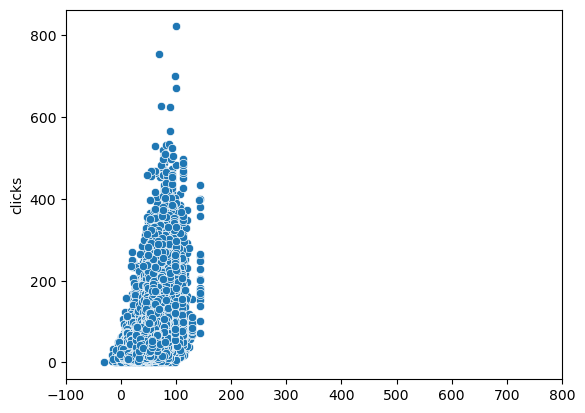

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = predictions, y = df['clicks'], ax=ax)
ax.set_xlim(-100,800)


## Extra:MLP Regressor model 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)
from sklearn.neural_network import MLPRegressor
MLP_regressor = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
predictions_mlp = MLP_regressor.predict(X_test)
r2_score(y_true=y_test,y_pred=predictions_mlp)


C:\Users\mldem\anaconda3\envs\causalclicker\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5172919406056982

(-100.0, 800.0)

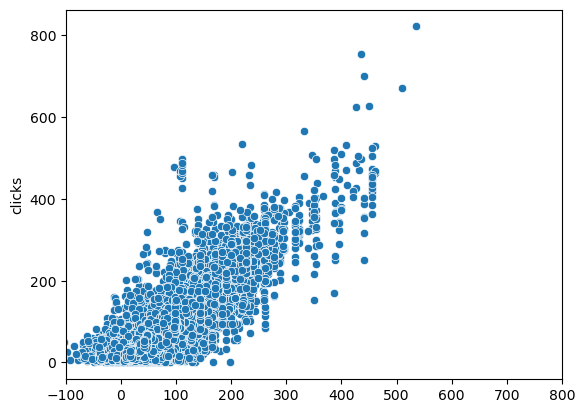

In [17]:

predictions_all = MLP_regressor.predict(stored_embeddings)

# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = predictions_all, y = df['clicks'], ax=ax)
ax.set_xlim(-100,800)


In [18]:
#Pair headlines based on clickability_test_id and eyecatcher_id
#Import dataset with pairs
df_pairs = pd.read_csv("headline_pair_indices.csv")
#Compute vector difference
embedding_diff = torch.stack(df_pairs.apply(lambda row: stored_embeddings[row['Idx_Headline1']] - stored_embeddings[row['Idx_Headline2']], axis=1).tolist()) 
#because we have a column where each row is a tensor so we kinda unpack them.
#Sort pairs s.t. headline1 is headline with more clicks. 
df_sorted_pairs = df_pairs.copy()
df_sorted_pairs.loc[~df_sorted_pairs["headline1_more_clicks"], ['Idx_Headline1', 'Idx_Headline2']] = df_sorted_pairs.loc[~df_sorted_pairs["headline1_more_clicks"], ['Idx_Headline2', 'Idx_Headline1']].values   

# 2 Predicting Headline-Winner based on SBert Embeddings with Logistic Regression

In [19]:
headline1_more_clicks = torch.tensor(df_pairs['headline1_more_clicks'])
X_train, X_test, y_train, y_test = train_test_split(embedding_diff, headline1_more_clicks, test_size=0.2)
logistic = LogisticRegression(max_iter=200)
logistic.fit(X_train, y_train)
predicted_logistic = logistic.predict(X_test)
accuracy_logistic = accuracy_score(predicted_logistic,y_test)
print("Accuracy predicting winner:", accuracy_logistic)

Accuracy predicting winner: 0.6262217045627184


# 3 Predicting Click difference based on SBert embeddings with Ridge Regression

In [20]:
#check shape matching and turning into tensors to work
clicks_diff = torch.tensor(abs(df_pairs['click_difference']))
#take sorted embeddings 
sorted_embedding_diff = torch.stack(df_sorted_pairs.apply(lambda row: stored_embeddings[row['Idx_Headline1']] - stored_embeddings[row['Idx_Headline2']], axis=1).tolist()) 

In [21]:
#Based on difference vector
X_train, X_test, y_train, y_test = train_test_split(sorted_embedding_diff, clicks_diff, test_size=0.2, random_state=seed)
ridge_model_diff =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_fit_diff = ridge_model_diff.fit(X_train, y_train)
ridge_fit_diff.score(X_train,y_train) #0.09528
ridge_predictions_diff = ridge_model_diff.predict(X_test)
ridge_rmse_diff = mean_squared_error(y_test, ridge_predictions_diff)
df_sorted_pairs["predictions"] = ridge_model_diff.predict(sorted_embedding_diff)
print("Ridge Regression MSE for clicks difference:", ridge_rmse_diff)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=ridge_predictions_diff)) 

Ridge Regression MSE for clicks difference: 250.27313508886158
Ridge Regression R2 for click difference: 0.03849809185468611


### Last 20 predicted

In [22]:

df.loc[df_sorted_pairs.sort_values(["predictions"], ascending=True).loc[:,'Idx_Headline1'][:20], ['headline', 'clicks']]



,headline,clicks
42159,So Now I'm Wondering If Toy Companies Even Wat...,94
16858,A Lesson On What *Not* To Say To Biracial People,72
99137,Giuliana Rancic proves it's possible to bounce...,23
16858,A Lesson On What *Not* To Say To Biracial People,72
77683,A Harvard Grad Turn Pro Wrestler Is Battling D...,20
30098,Do Mother's Day Like A Pro,11
32803,The Office Battle To End All Office Battles,34
4956,A New Way To See The World That's So Futuristi...,25
37090,Earth To Women: Stay Right There,65
56040,"A Caricature Of Women, Care Of Yogurt Companies",31


In [23]:
#### Possible explanations:
#### 1.
#### 2.

### Top 20 predicted

In [24]:
df.loc[df_sorted_pairs.sort_values(["predictions"], ascending=False).loc[:,'Idx_Headline1'][:20], ['headline', 'clicks']]


,headline,clicks
78573,A Dad Took These Photos Of His Daughter. They'...,81
55951,You May Be Startled By Where This Girl Ends Up...,47
77299,The Sad Thing That Little Girl Told Him On The...,39
18920,The Doctors Thought His Mom Would Reject Him. ...,152
91090,A Funny Old Lady Finally Says What She Thinks ...,57
72482,A Camera Follows A Guy To Show Something We're...,57
74889,A Girl Said Something Really Racist To This Gu...,77
17114,A Girl Said Something Really Racist To This Gu...,96
41882,At 5pm The Mans Daughter Was Sick. By 7pm She ...,124
45379,A Dad Scolds His Homophobic Daughter In This B...,219


#### Posible explanations:
#### 1. Beginning of a story - i.e a man screamed, an interviewer asks..
#### 2. Capital letters

(-100.0, 450.0)

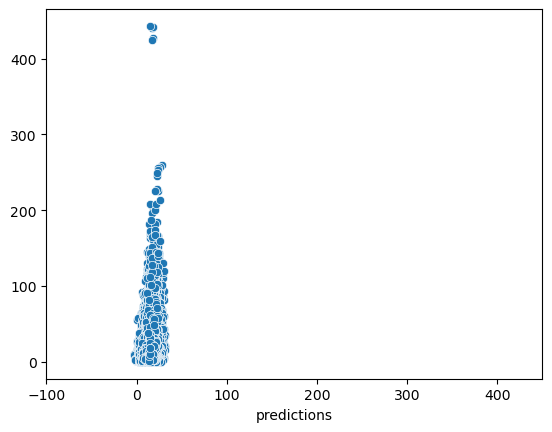

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = df_sorted_pairs['predictions'], y = clicks_diff, ax=ax)
ax.set_xlim(-100,450)
## this is super sketchy. 

### Compare headline ranking between true click difference and predicted click difference

In [26]:


# there has to be a better way!
predicted_ranking = df_sorted_pairs.sort_values(['predictions'])['Idx_Headline1'].astype(str).values+df_sorted_pairs.sort_values(['predictions'])['Idx_Headline2'].astype(str).values
true_ranking = df_sorted_pairs.sort_values(['click_difference'])['Idx_Headline1'].astype(str).values+df_sorted_pairs.sort_values(['click_difference'])['Idx_Headline2'].astype(str).values

print("Spearman correlation is",spearmanr(predicted_ranking, true_ranking))

Spearman correlation is SignificanceResult(statistic=0.0035262837510733965, pvalue=0.267859265800468)


# Extra: Prediction based on concatenated full embeddings

In [27]:
## Here we need to make sure the headline ordering is correct so we use sorted pairs 
#Compute concatenated embeddings of the pairs
vec1 = df_sorted_pairs.apply(lambda row:(stored_embeddings[row['Idx_Headline1']]), axis=1)
vec1= torch.stack(vec1.tolist())
vec2 = df_sorted_pairs.apply(lambda row:(stored_embeddings[row['Idx_Headline2']]), axis=1)
vec2= torch.stack(vec2.tolist())
concatenated_vector = torch.cat([vec1, vec2], dim=1)
print(concatenated_vector)

tensor([[-0.0639,  0.1315, -0.1852,  ...,  0.1781,  0.1700, -0.2824],
        [ 0.0265,  0.0478,  0.2955,  ...,  0.1285, -0.0735, -0.2070],
        [ 0.0265,  0.0478,  0.2955,  ..., -0.5914,  0.7509, -0.2418],
        ...,
        [ 0.2242, -0.0074, -0.0443,  ...,  0.0541, -0.1859, -0.2557],
        [ 0.1863, -0.0445, -0.3540,  ...,  0.0511,  0.0482, -0.0710],
        [ 0.2242, -0.0074, -0.0443,  ...,  0.0511,  0.0482, -0.0710]])


In [28]:
#Based on concatenated full embeddings
X_train, X_test, y_train, y_test = train_test_split(concatenated_vector, clicks_diff, test_size=0.2)

In [29]:
# Ridge Model
ridge_model_diff =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_fit_diff = ridge_model_diff.fit(X_train, y_train)
ridge_fit_diff.score(X_train,y_train) #0.01513
ridge_predictions_diff = ridge_model_diff.predict(X_test)
ridge_rmse_diff = mean_squared_error(y_test, ridge_predictions_diff)
print("Ridge Regression MSE for clicks difference:", ridge_rmse_diff)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=ridge_predictions_diff)) 


Ridge Regression MSE for clicks difference: 240.2112715741381
Ridge Regression R2 for click difference: 0.08347898452229352


In [30]:
# Linear Model
lin_model_diff = LinearRegression()
lin_fit_diff = lin_model_diff.fit(X_train, y_train)
lin_fit_diff.score(X_train,y_train)
lin_predictions_diff = lin_model_diff.predict(X_test)
lin_rmse_diff = mean_squared_error(y_test, lin_predictions_diff)
print("Linear Regression MSE for clicks difference:", lin_rmse_diff) #Result is better with linear regression
print("Linear Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=lin_predictions_diff)) 

Linear Regression MSE for clicks difference: 240.25286481099855
Linear Regression R2 for click difference: 0.08332028640861
